# **-------------- Classification ---------------**

In [ ]:
import logging

# Remove all handlers associated with the root logger (Jupyter attaches its own by default)
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Reconfigure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

logger.info("Logger is now configured correctly.")


2025-05-08 15:46:07,535 - INFO - Logger is now configured correctly.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, multilabel_confusion_matrix, confusion_matrix
from sklearn.feature_selection import mutual_info_classif
from sklearn.multioutput import MultiOutputClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

logger.info("All libraries for Classification imported successfully.")


2025-05-08 15:04:16,639 - INFO - All libraries for Classification imported successfully.


## **Model Building**

### **XGBoost**

In [ ]:
# Define the base XGBoost model
base_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Wrap in MultiOutputClassifier
multi_model = MultiOutputClassifier(base_model)

# Define parameter grid
param_grid = {
    'estimator__n_estimators': [50, 100],
    'estimator__learning_rate': [0.05, 0.1],
    'estimator__max_depth': [3, 5]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    multi_model,
    param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit to training data
grid_search.fit(X_train_scaled, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:05:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:05:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:06:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:06:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:06:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Best Parameters: {'estimator__learning_rate': 0.1, 'estimator__max_depth': 5, 'estimator__n_estimators': 100}
Best CV Accuracy: 0.9499999999999998


#### Model Evaluation

In [ ]:
# Already trained best model
best_model = grid_search.best_estimator_

y_train_pred = best_model.predict(X_train_scaled)
training_accuracy = accuracy_score(y_train, y_train_pred)
print("XGBoost Train Accuracy:", training_accuracy)

y_pred = best_model.predict(X_test_scaled)
print("XGBoost Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Confusion Matrices
cm = multilabel_confusion_matrix(y_test, y_pred)
for i, label in enumerate(target_columns):
    print(f"Confusion matrix for {label}:")
    print(cm[i])

XGBoost Train Accuracy: 0.97625
XGBoost Test Accuracy: 0.9578333333333333
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3366
           1       0.99      0.96      0.97      3117
           2       1.00      1.00      1.00      2694
           3       0.99      0.98      0.99      1832
           4       1.00      1.00      1.00      3544

   micro avg       1.00      0.99      0.99     14553
   macro avg       1.00      0.99      0.99     14553
weighted avg       1.00      0.99      0.99     14553
 samples avg       0.96      0.95      0.95     14553

Confusion matrix for Diabetes:
[[2633    1]
 [   7 3359]]
Confusion matrix for Anemia:
[[2842   41]
 [ 140 2977]]
Confusion matrix for Kidney Failure:
[[3303    3]
 [   3 2691]]
Confusion matrix for Liver Failure:
[[4156   12]
 [  35 1797]]
Confusion matrix for Ischimic Heart Disease:
[[2451    5]
 [   8 3536]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### **Neural Network**

In [ ]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(96, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(32, activation='relu'),
    BatchNormalization(),

    # Output layer for 5 classes (multi-label classification)
    Dense(5, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    min_delta=0.001  # Minimum change to qualify as improvement
)

# Train Model with larger batch size
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

# Threshold predictions at 0.5 for multi-label classification
y_pred_train = (model.predict(X_train) > 0.5).astype(int)
y_pred_test = (model.predict(X_test) > 0.5).astype(int)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.6692 - val_loss: 0.4067
Epoch 2/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4162 - val_loss: 0.2743
Epoch 3/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.3433 - val_loss: 0.2429
Epoch 4/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3120 - val_loss: 0.2289
Epoch 5/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3003 - val_loss: 0.2183
Epoch 6/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2859 - val_loss: 0.2101
Epoch 7/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2728 - val_loss: 0.2042
Epoch 8/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.2666 - val_loss: 0.1975
Epoch 9/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2585 - val_loss: 0.1926
Epoch 10/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.2490 - val_loss: 0.1886
Epoch 11/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.2418 - val_loss: 0.1829
Epoch 12/100
300/300 ━━━━━━━━━━━━━━━━━━━━

Evaluation

In [ ]:
# Convert predictions and true labels to numpy arrays if they aren't already
y_test_np = y_test.values if hasattr(y_test, 'values') else y_test
y_pred_test_np = y_pred_test.values if hasattr(y_pred_test, 'values') else y_pred_test

# Evaluation metrics for each condition
conditions = ['Diabetes', 'Anemia', 'Kidney Failure', 'Liver Failure', 'Ischemic Heart Disease']

print("\nOverall Accuracy Scores:")
print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Test Accuracy:", accuracy_score(y_test_np, y_pred_test_np))

print("\nPer-Condition Classification Reports:")
for i, condition in enumerate(conditions):
    print(f"\n{condition}:")
    print(classification_report(y_test_np[:, i], y_pred_test_np[:, i]))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test_np[:, i], y_pred_test_np[:, i]))


Overall Accuracy Scores:
Train Accuracy: 0.8484583333333333
Test Accuracy: 0.8243333333333334

Per-Condition Classification Reports:

Diabetes:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2634
           1       1.00      1.00      1.00      3366

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000

Confusion Matrix:
[[2632    2]
 [  13 3353]]

Anemia:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      2883
           1       0.92      0.92      0.92      3117

    accuracy                           0.92      6000
   macro avg       0.92      0.92      0.92      6000
weighted avg       0.92      0.92      0.92      6000

Confusion Matrix:
[[2639  244]
 [ 242 2875]]

Kidney Failure:
              precision    recall  f1-score   support

           0       0.97      0

#### **Models Comparison**

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me

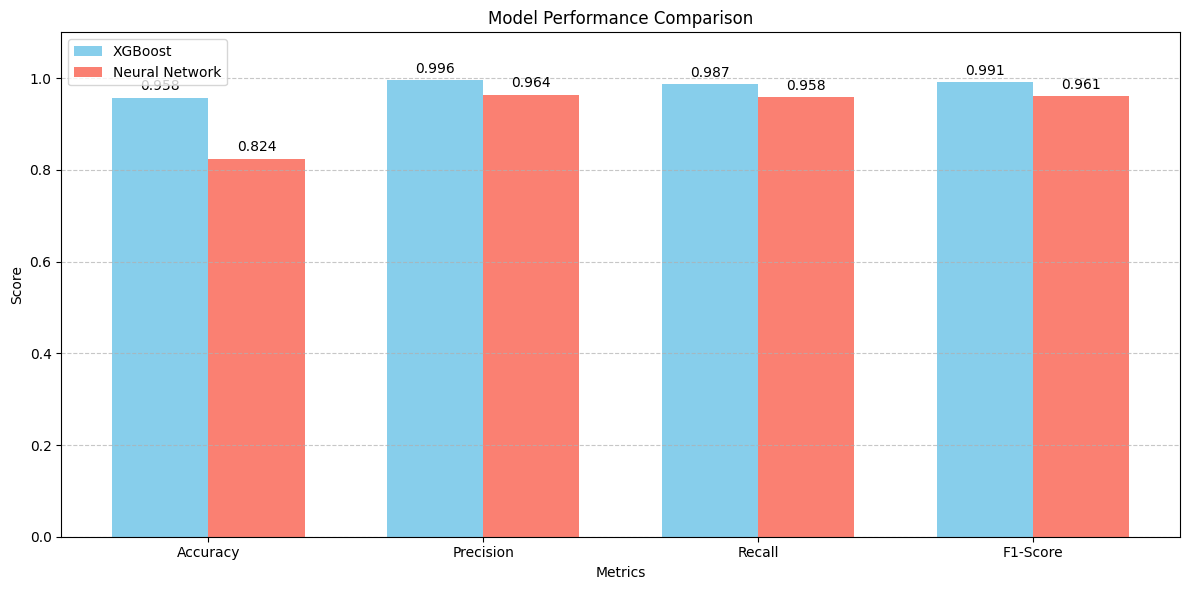

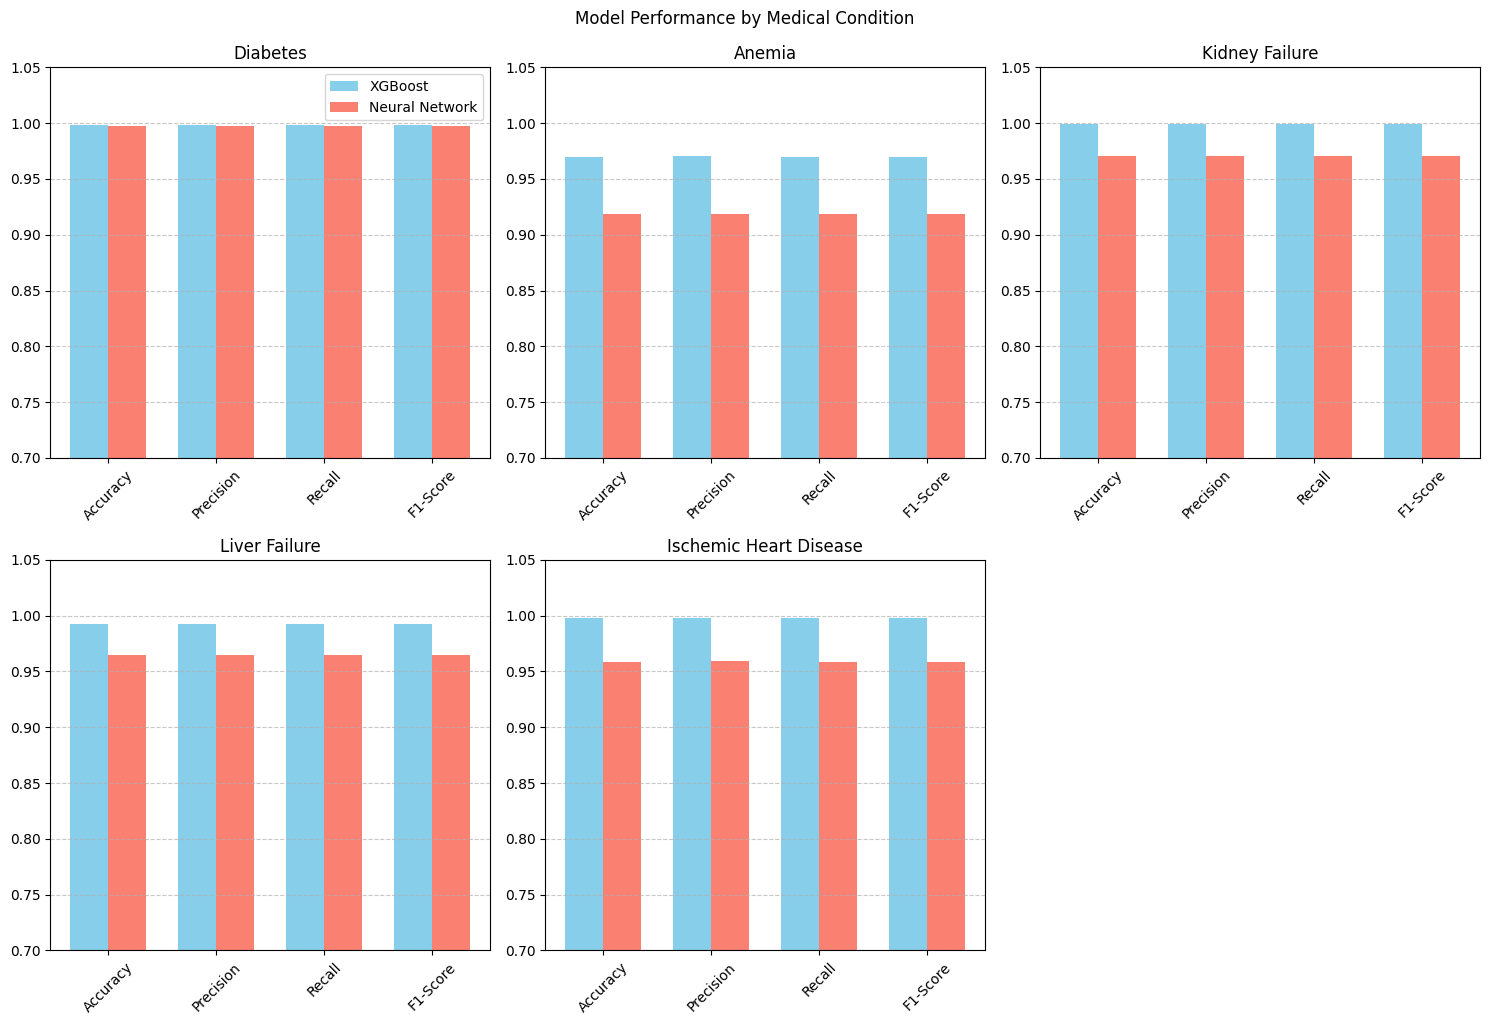

In [ ]:
# Prepare the data
model_names = ['XGBoost', 'Neural Network']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

# Calculate metrics for XGBoost (from your code)
xgboost_report = classification_report(y_test, y_pred, output_dict=True)
xgboost_metrics = [
    accuracy_score(y_test, y_pred),
    xgboost_report['weighted avg']['precision'],
    xgboost_report['weighted avg']['recall'],
    xgboost_report['weighted avg']['f1-score']
]

# Calculate metrics for Neural Network (from your code)
nn_report = classification_report(y_test_np, y_pred_test_np, output_dict=True)
nn_metrics = [
    accuracy_score(y_test_np, y_pred_test_np),
    nn_report['weighted avg']['precision'],
    nn_report['weighted avg']['recall'],
    nn_report['weighted avg']['f1-score']
]

# Create the comparison plot
plt.figure(figsize=(12, 6))
x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, xgboost_metrics, width, label='XGBoost', color='skyblue')
plt.bar(x + width/2, nn_metrics, width, label='Neural Network', color='salmon')

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, metrics)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Add values on top of bars
for i in range(len(metrics)):
    plt.text(i - width/2, xgboost_metrics[i] + 0.01, f'{xgboost_metrics[i]:.3f}',
             ha='center', va='bottom')
    plt.text(i + width/2, nn_metrics[i] + 0.01, f'{nn_metrics[i]:.3f}',
             ha='center', va='bottom')

plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()

# Condition-specific comparison
conditions = ['Diabetes', 'Anemia', 'Kidney Failure', 'Liver Failure', 'Ischemic Heart Disease']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

plt.figure(figsize=(15, 10))
for i, condition in enumerate(conditions):
    # Get XGBoost metrics for this condition
    xg_cond_report = classification_report(y_test.iloc[:, i], y_pred[:, i], output_dict=True)
    xg_cond_metrics = [
        accuracy_score(y_test.iloc[:, i], y_pred[:, i]),
        xg_cond_report['weighted avg']['precision'],
        xg_cond_report['weighted avg']['recall'],
        xg_cond_report['weighted avg']['f1-score']
    ]

    # Get Neural Network metrics for this condition
    nn_cond_report = classification_report(y_test_np[:, i], y_pred_test_np[:, i], output_dict=True)
    nn_cond_metrics = [
        accuracy_score(y_test_np[:, i], y_pred_test_np[:, i]),
        nn_cond_report['weighted avg']['precision'],
        nn_cond_report['weighted avg']['recall'],
        nn_cond_report['weighted avg']['f1-score']
    ]

    plt.subplot(2, 3, i+1)
    x = np.arange(len(metrics))
    width = 0.35

    plt.bar(x - width/2, xg_cond_metrics, width, label='XGBoost', color='skyblue')
    plt.bar(x + width/2, nn_cond_metrics, width, label='Neural Network', color='salmon')

    plt.title(condition)
    plt.xticks(x, metrics, rotation=45)
    plt.ylim(0.7, 1.05)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)

    if i == 0:
        plt.legend()

plt.tight_layout()
plt.suptitle('Model Performance by Medical Condition', y=1.02)
plt.show()

# **---------------- Progression ----------------**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, roc_curve, auc, confusion_matrix
from xgboost import XGBRegressor, XGBClassifier
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

logger.info("All libraries for Progression imported successfully.")

2025-05-08 15:09:19,847 - INFO - All libraries for Progression imported successfully.


## **Anemia_progression**

### **Model Building**

In [ ]:
# Store models and results to compare later
models = {}
results = {}

1. **Linear Regression with ridge regularization**

In [ ]:
# 1. Ridge Regression
ridge = Ridge()
ridge_params = {
    'alpha': [0.01, 0.1, 1, 10, 100]
}
ridge_grid = GridSearchCV(ridge, ridge_params, cv=5, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train, y_train)
y_pred_ridge = ridge_grid.predict(X_test)

models['Ridge'] = ridge_grid.best_estimator_
results['Ridge'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_ridge)),
    'R2': r2_score(y_test, y_pred_ridge),
    'Params': ridge_grid.best_params_
}
logger.info(f"Ridge Regression evaluation complete. RMSE: {results['Ridge']['RMSE']:.4f}, R2: {results['Ridge']['R2']:.4f}, Best Params: {results['Ridge']['Params']}")


2025-05-08 15:56:51,055 - INFO - Ridge Regression evaluation complete. RMSE: 19.9749, R2: 0.5349, Best Params: {'alpha': 0.1}


2. **Neural Network**

In [ ]:
# --- Define NN Architecture ---
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1)  # Linear output for regression
])

# --- Compile the Model ---
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mse',
              metrics=['mse'])

# --- Train with Early Stopping ---
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# --- Extract Hyperparameters ---
def get_model_params(model):
    params = {}

    # Optimizer parameters
    if hasattr(model.optimizer, 'learning_rate'):
        params['learning_rate'] = float(model.optimizer.learning_rate.numpy())

    # Layer-specific parameters
    for layer in model.layers:
        if isinstance(layer, Dense):
            params[f'dense_units_{layer.name}'] = layer.units
            params[f'activation_{layer.name}'] = layer.activation.__name__
        elif isinstance(layer, Dropout):
            params[f'dropout_rate_{layer.name}'] = layer.rate
        elif isinstance(layer, BatchNormalization):
            params[f'batchnorm_{layer.name}'] = True

        return params

# --- Predict & Evaluate ---
y_pred_nn = model.predict(X_test).flatten()

# Store results
models['Neural Network'] = model
results['Neural Network'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_nn)),
    'R2': r2_score(y_test, y_pred_nn),
    'Params': get_model_params(model)
}


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1900.0963 - mse: 1900.0963 - val_loss: 1203.1809 - val_mse: 1203.1809
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 907.9626 - mse: 907.9626 - val_loss: 394.9155 - val_mse: 394.9155
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 387.5021 - mse: 387.5021 - val_loss: 239.4400 - val_mse: 239.4400
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 328.5531 - mse: 328.5531 - val_loss: 227.8066 - val_mse: 227.8066
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 308.3372 - mse: 308.3372 - val_loss: 228.7511 - val_mse: 228.7511
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 311.4362 - mse: 311.4362 - val_loss: 226.4407 - val_mse: 226.4407
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 302.8342 - mse: 302.8342 - val_loss: 213.6899 - val_mse: 213.6899
Epoch 8/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 285.4219 - mse: 285.4219 - val_loss: 215.3128 - val_mse: 215.3128

3. **XGBoost Regressor**

In [ ]:
# 3. XGBoost Regressor
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize base model
xgb_base = XGBRegressor(random_state=42)

# Grid search with 3-fold cross-validation
grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred_xgb = best_model.predict(X_test)

models['XGBoost'] = grid_search.best_params_
results['XGBoost'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_xgb)),
    'R2': r2_score(y_test, y_pred_xgb),
    'Params': grid_search.best_params_
}


Fitting 3 folds for each of 72 candidates, totalling 216 fits


**Models Evaluation and comparison**

In [ ]:
print("Model Comparison:")
for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f"  RMSE        = {metrics['RMSE']:.2f}")
    print(f"  R²          = {metrics['R2']:.4f}")
    print(f"  Params = {metrics['Params']}")

Model Comparison:
Ridge:
  RMSE        = 19.97
  R²          = 0.5349
  Params = {'alpha': 0.1}
Neural Network:
  RMSE        = 13.63
  R²          = 0.7833
  Params = {'learning_rate': 0.0010000000474974513, 'dense_units_dense_5': 64, 'activation_dense_5': 'relu'}
XGBoost:
  RMSE        = 11.79
  R²          = 0.8378
  Params = {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}


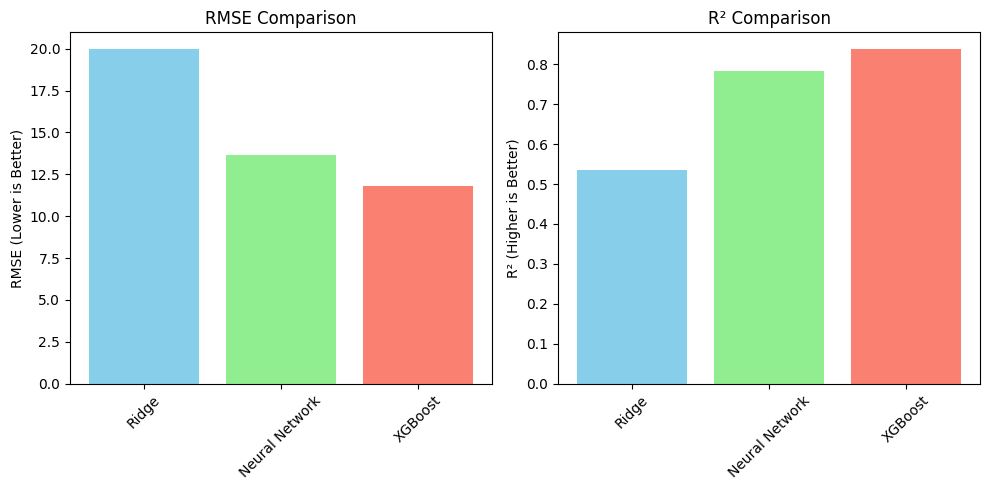

In [ ]:
# Extract metrics
model_names = list(results.keys())
rmse_values = [results[model]['RMSE'] for model in model_names]
r2_values = [results[model]['R2'] for model in model_names]

# Plot RMSE
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(model_names, rmse_values, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('RMSE Comparison')
plt.ylabel('RMSE (Lower is Better)')
plt.xticks(rotation=45)

# Plot R²
plt.subplot(1, 2, 2)
plt.bar(model_names, r2_values, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('R² Comparison')
plt.ylabel('R² (Higher is Better)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


## **Diabetes_progression**

### Model training and Evaluation

In [ ]:
# Store models and results to compare later
models = {}
results = {}

1. **Linear Regression with Ridge Regularization**

In [ ]:
# 1. Ridge Regression
ridge = Ridge()
ridge_params = {
    'alpha': [0.01, 0.1, 1, 10, 100]
}
ridge_grid = GridSearchCV(ridge, ridge_params, cv=5, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train, y_train_reg)
y_pred_ridge = ridge_grid.predict(X_test)

models['Ridge'] = ridge_grid.best_estimator_
results['Ridge'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test_reg, y_pred_ridge)),
    'R2': r2_score(y_test_reg, y_pred_ridge),
    'Params': ridge_grid.best_params_
}

logger.info(f"Ridge Regression evaluation complete. RMSE: {results['Ridge']['RMSE']:.4f}, R2: {results['Ridge']['R2']:.4f}, Best Params: {results['Ridge']['Params']}")

2025-05-08 15:57:50,256 - INFO - Ridge Regression evaluation complete. RMSE: 9.4655, R2: 0.8619, Best Params: {'alpha': 0.01}


2. **Neural Network**

In [ ]:
# --- Define NN Architecture ---
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1)  # Linear output for regression
])

# --- Compile the Model ---
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mse',
              metrics=['mse'])

# --- Train with Early Stopping ---
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train_reg,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# --- Extract Hyperparameters ---
def get_model_params(model):
    params = {}

    # Optimizer parameters
    if hasattr(model.optimizer, 'learning_rate'):
        params['learning_rate'] = float(model.optimizer.learning_rate.numpy())

    # Layer-specific parameters
    for layer in model.layers:
        if isinstance(layer, Dense):
            params[f'dense_units_{layer.name}'] = layer.units
            params[f'activation_{layer.name}'] = layer.activation.__name__
        elif isinstance(layer, Dropout):
            params[f'dropout_rate_{layer.name}'] = layer.rate
        elif isinstance(layer, BatchNormalization):
            params[f'batchnorm_{layer.name}'] = True

        return params

# --- Predict & Evaluate ---
y_pred_nn = model.predict(X_test).flatten()

# Store results
models['Neural Network'] = model
results['Neural Network'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test_reg, y_pred_nn)),
    'R2': r2_score(y_test_reg, y_pred_nn),
    'Params': get_model_params(model)
}

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1271.6587 - mse: 1271.6587 - val_loss: 488.4923 - val_mse: 488.4923
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 421.9931 - mse: 421.9931 - val_loss: 81.5976 - val_mse: 81.5976
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 103.9572 - mse: 103.9572 - val_loss: 22.6336 - val_mse: 22.6336
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 66.0870 - mse: 66.0870 - val_loss: 17.7919 - val_mse: 17.7919
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 60.3371 - mse: 60.3371 - val_loss: 17.6738 - val_mse: 17.6738
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 60.6915 - mse: 60.6915 - val_loss: 14.6839 - val_mse: 14.6839
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 58.7122 - mse: 58.7122 - val_loss: 14.9712 - val_mse: 14.9712
Epoch 8/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 58.5278 - mse: 58.5278 - val_loss: 14.8354 - val_mse: 14.8354
Epoch 9/50
400/400 ━━━━━━

3. **XGBoost Regressor**

In [ ]:
# 3. XGBoost Regressor
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize base model
xgb_base = XGBRegressor(random_state=42)

# Grid search with 3-fold cross-validation
grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train_reg)

best_model = grid_search.best_estimator_
y_pred_xgb = best_model.predict(X_test)

models['XGBoost'] = grid_search.best_params_
results['XGBoost'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test_reg, y_pred_xgb)),
    'R2': r2_score(y_test_reg, y_pred_xgb),
    'Params': grid_search.best_params_
}

Fitting 3 folds for each of 72 candidates, totalling 216 fits


Models Comparison

Model Comparison:
Ridge:
  RMSE        = 9.47
  R²          = 0.8619
  Params = {'alpha': 0.01}
Neural Network:
  RMSE        = 3.50
  R²          = 0.9811
  Params = {'learning_rate': 0.0010000000474974513, 'dense_units_dense_8': 64, 'activation_dense_8': 'relu'}
XGBoost:
  RMSE        = 2.31
  R²          = 0.9917
  Params = {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}


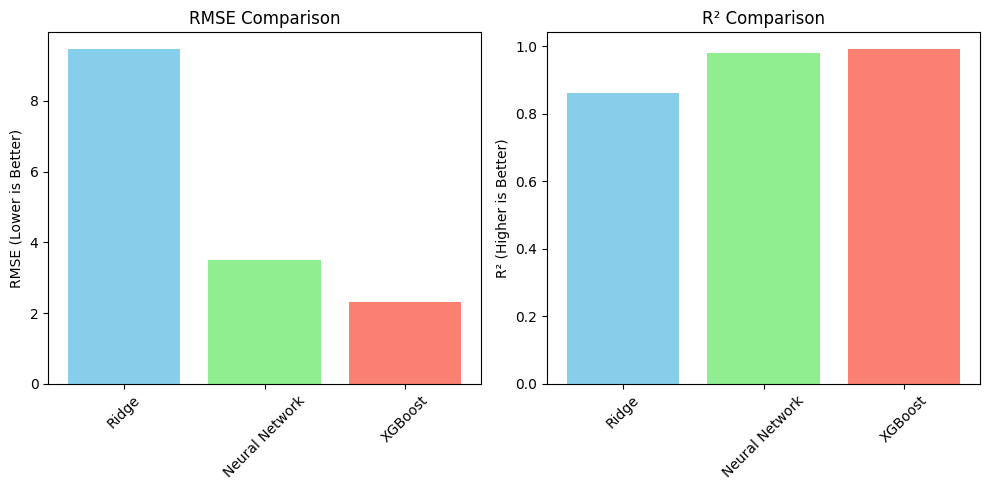

In [ ]:
print("Model Comparison:")
for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f"  RMSE        = {metrics['RMSE']:.2f}")
    print(f"  R²          = {metrics['R2']:.4f}")
    print(f"  Params = {metrics['Params']}")

# Extract metrics
model_names = list(results.keys())
rmse_values = [results[model]['RMSE'] for model in model_names]
r2_values = [results[model]['R2'] for model in model_names]

# Plot RMSE
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(model_names, rmse_values, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('RMSE Comparison')
plt.ylabel('RMSE (Lower is Better)')
plt.xticks(rotation=45)

# Plot R²
plt.subplot(1, 2, 2)
plt.bar(model_names, r2_values, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('R² Comparison')
plt.ylabel('R² (Higher is Better)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


#### **XGBoost Classification**

Best Classification Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
XGBoost Classification Train Accuracy: 0.99325
XGBoost Classification Test Accuracy: 0.99325
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1224
           1       1.00      0.99      1.00      1406
           2       1.00      0.99      0.99      1370

    accuracy                           0.99      4000
   macro avg       0.99      0.99      0.99      4000
weighted avg       0.99      0.99      0.99      4000



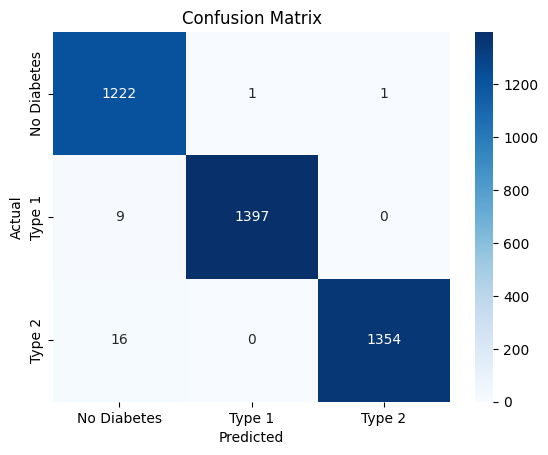

In [ ]:
cls_params = {
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}
xgb_cls = XGBClassifier(objective='multi:softmax', num_class=3, random_state=42)
grid_cls = GridSearchCV(xgb_cls, cls_params, cv=3, scoring='accuracy')
grid_cls.fit(X_train_scaled, y_train_cls)

print("Best Classification Params:", grid_cls.best_params_)

y_train_pred_cls = grid_cls.predict(X_train_scaled)
y_pred_cls = grid_cls.predict(X_test_scaled)

train_acc = accuracy_score(y_train_cls, y_train_pred_cls)
print("XGBoost Classification Train Accuracy:", train_acc)
acc = accuracy_score(y_test_cls, y_pred_cls)
print("XGBoost Classification Test Accuracy:", acc)
print("Classification Report:\n", classification_report(y_test_cls, y_pred_cls))

# Confusion Matrix
cm = confusion_matrix(y_test_cls, y_pred_cls)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Diabetes', 'Type 1', 'Type 2'],
            yticklabels=['No Diabetes', 'Type 1', 'Type 2'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## **Kidney_disease Progression**

### Model Training and Evaluation

In [ ]:
X_train = X_train_scaled
X_test = X_test_scaled

In [ ]:
# Store models and results to compare later
models = {}
results = {}

1. **Linear Regression with Ridge regularization**

In [ ]:
# 1. Ridge Regression
ridge = Ridge()
ridge_params = {
    'alpha': [0.01, 0.1, 1, 10, 100]
}
ridge_grid = GridSearchCV(ridge, ridge_params, cv=5, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train, y_train)
y_pred_ridge = ridge_grid.predict(X_test)

models['Ridge'] = ridge_grid.best_estimator_
results['Ridge'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_ridge)),
    'R2': r2_score(y_test, y_pred_ridge),
    'Params': ridge_grid.best_params_
}

logger.info(f"Ridge Regression evaluation complete. RMSE: {results['Ridge']['RMSE']:.4f}, R2: {results['Ridge']['R2']:.4f}, Best Params: {results['Ridge']['Params']}")

2025-05-08 16:03:15,941 - INFO - Ridge Regression evaluation complete. RMSE: 7.6548, R2: 0.9321, Best Params: {'alpha': 0.01}


2. **Neural Network**

In [ ]:
# --- Define NN Architecture ---
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1)  # Linear output for regression
])

# --- Compile the Model ---
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mse',
              metrics=['mse'])

# --- Train with Early Stopping ---
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# --- Extract Hyperparameters ---
def get_model_params(model):
    params = {}

    # Optimizer parameters
    if hasattr(model.optimizer, 'learning_rate'):
        params['learning_rate'] = float(model.optimizer.learning_rate.numpy())

    # Layer-specific parameters
    for layer in model.layers:
        if isinstance(layer, Dense):
            params[f'dense_units_{layer.name}'] = layer.units
            params[f'activation_{layer.name}'] = layer.activation.__name__
        elif isinstance(layer, Dropout):
            params[f'dropout_rate_{layer.name}'] = layer.rate
        elif isinstance(layer, BatchNormalization):
            params[f'batchnorm_{layer.name}'] = True

        return params

# --- Predict & Evaluate ---
y_pred_nn = model.predict(X_test).flatten()

# Store results
models['Neural Network'] = model
results['Neural Network'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_nn)),
    'R2': r2_score(y_test, y_pred_nn),
    'Params': get_model_params(model)
}

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1941.0184 - mse: 1941.0184 - val_loss: 866.3293 - val_mse: 866.3293
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 724.2277 - mse: 724.2277 - val_loss: 205.8445 - val_mse: 205.8445
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 188.7479 - mse: 188.7479 - val_loss: 29.9126 - val_mse: 29.9126
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 79.1470 - mse: 79.1470 - val_loss: 17.0494 - val_mse: 17.0494
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 81.9442 - mse: 81.9442 - val_loss: 15.4000 - val_mse: 15.4000
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 72.7427 - mse: 72.7427 - val_loss: 14.2523 - val_mse: 14.2523
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 74.0508 - mse: 74.0508 - val_loss: 13.7584 - val_mse: 13.7584
Epoch 8/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 69.7485 - mse: 69.7485 - val_loss: 13.1588 - val_mse: 13.1588
Epoch 9/50
400/400 ━━━━

3. **XGBoost Rgressor**

In [ ]:
# 3. XGBoost Regressor
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize base model
xgb_base = XGBRegressor(random_state=42)

# Grid search with 3-fold cross-validation
grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred_xgb = best_model.predict(X_test)

models['XGBoost'] = grid_search.best_params_
results['XGBoost'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_xgb)),
    'R2': r2_score(y_test, y_pred_xgb),
    'Params': grid_search.best_params_
}

Fitting 3 folds for each of 72 candidates, totalling 216 fits


**Models Evaluation and Comparison**

Model Comparison:
Ridge:
  RMSE        = 7.65
  R²          = 0.9321
  Params = {'alpha': 0.1}
Neural Network:
  RMSE        = 2.62
  R²          = 0.9920
  Params = {'learning_rate': 0.0010000000474974513, 'dense_units_dense_11': 64, 'activation_dense_11': 'relu'}
XGBoost:
  RMSE        = 1.48
  R²          = 0.9975
  Params = {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


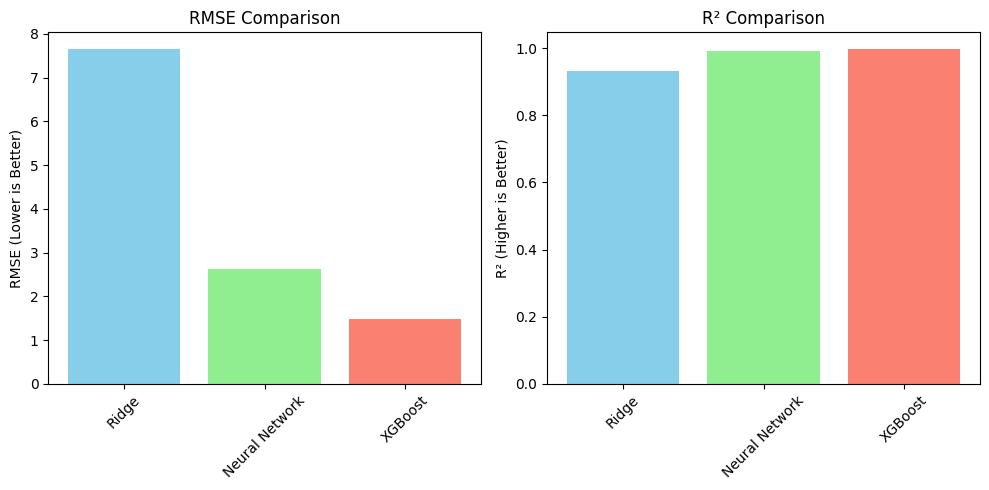

In [ ]:
print("Model Comparison:")
for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f"  RMSE        = {metrics['RMSE']:.2f}")
    print(f"  R²          = {metrics['R2']:.4f}")
    print(f"  Params = {metrics['Params']}")

# %%
# Extract metrics
model_names = list(results.keys())
rmse_values = [results[model]['RMSE'] for model in model_names]
r2_values = [results[model]['R2'] for model in model_names]

# Plot RMSE
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(model_names, rmse_values, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('RMSE Comparison')
plt.ylabel('RMSE (Lower is Better)')
plt.xticks(rotation=45)

# Plot R²
plt.subplot(1, 2, 2)
plt.bar(model_names, r2_values, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('R² Comparison')
plt.ylabel('R² (Higher is Better)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


## **liver_disease Progression**

### Model Training and Evaluation

In [ ]:
X_train = X_train_scaled
X_test = X_test_scaled

In [ ]:
# Store models and results to compare later
models = {}
results = {}

1. **Linear Regression with Ridge Regularization**

In [ ]:
# 1. Ridge Regression
ridge = Ridge()
ridge_params = {
    'alpha': [0.01, 0.1, 1, 10, 100]
}
ridge_grid = GridSearchCV(ridge, ridge_params, cv=5, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train, y_train)
y_pred_ridge = ridge_grid.predict(X_test)

models['Ridge'] = ridge_grid.best_estimator_
results['Ridge'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_ridge)),
    'R2': r2_score(y_test, y_pred_ridge),
    'Params': ridge_grid.best_params_
}

logger.info(f"Ridge Regression evaluation complete. RMSE: {results['Ridge']['RMSE']:.4f}, R2: {results['Ridge']['R2']:.4f}, Best Params: {results['Ridge']['Params']}")


2025-05-08 16:04:03,736 - INFO - Ridge Regression evaluation complete. RMSE: 9.3778, R2: 0.8698, Best Params: {'alpha': 0.1}


2. **Neural Network**

In [ ]:
# --- Define NN Architecture ---
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1)  # Linear output for regression
])

# --- Compile the Model ---
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mse',
              metrics=['mse'])

# --- Train with Early Stopping ---
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# --- Extract Hyperparameters ---
def get_model_params(model):
    params = {}

    # Optimizer parameters
    if hasattr(model.optimizer, 'learning_rate'):
        params['learning_rate'] = float(model.optimizer.learning_rate.numpy())

    # Layer-specific parameters
    for layer in model.layers:
        if isinstance(layer, Dense):
            params[f'dense_units_{layer.name}'] = layer.units
            params[f'activation_{layer.name}'] = layer.activation.__name__
        elif isinstance(layer, Dropout):
            params[f'dropout_rate_{layer.name}'] = layer.rate
        elif isinstance(layer, BatchNormalization):
            params[f'batchnorm_{layer.name}'] = True

        return params

# --- Predict & Evaluate ---
y_pred_nn = model.predict(X_test).flatten()

# Store results
models['Neural Network'] = model
results['Neural Network'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_nn)),
    'R2': r2_score(y_test, y_pred_nn),
    'Params': get_model_params(model)
}

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1444.9980 - mse: 1444.9980 - val_loss: 608.5887 - val_mse: 608.5887
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 486.1466 - mse: 486.1466 - val_loss: 142.4138 - val_mse: 142.4138
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 117.2219 - mse: 117.2219 - val_loss: 43.3887 - val_mse: 43.3887
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 77.3310 - mse: 77.3310 - val_loss: 30.6032 - val_mse: 30.6032
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 77.6233 - mse: 77.6233 - val_loss: 22.9464 - val_mse: 22.9464
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 72.7571 - mse: 72.7571 - val_loss: 21.3589 - val_mse: 21.3589
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 64.7026 - mse: 64.7026 - val_loss: 21.6057 - val_mse: 21.6057
Epoch 8/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 63.9824 - mse: 63.9824 - val_loss: 21.1841 - val_mse: 21.1841
Epoch 9/50
400/400 ━━━━

3. **XGBoost Regressor**

In [ ]:
# 3. XGBoost Regressor
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize base model
xgb_base = XGBRegressor(random_state=42)

# Grid search with 3-fold cross-validation
grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred_xgb = best_model.predict(X_test)

models['XGBoost'] = grid_search.best_params_
results['XGBoost'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_xgb)),
    'R2': r2_score(y_test, y_pred_xgb),
    'Params': grid_search.best_params_
}

Fitting 3 folds for each of 72 candidates, totalling 216 fits


**Models Comparison**

Model Comparison:
Ridge:
  RMSE        = 9.38
  R²          = 0.8698
  Params = {'alpha': 0.1}
Neural Network:
  RMSE        = 3.82
  R²          = 0.9784
  Params = {'learning_rate': 0.0010000000474974513, 'dense_units_dense_14': 64, 'activation_dense_14': 'relu'}
XGBoost:
  RMSE        = 2.13
  R²          = 0.9933
  Params = {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


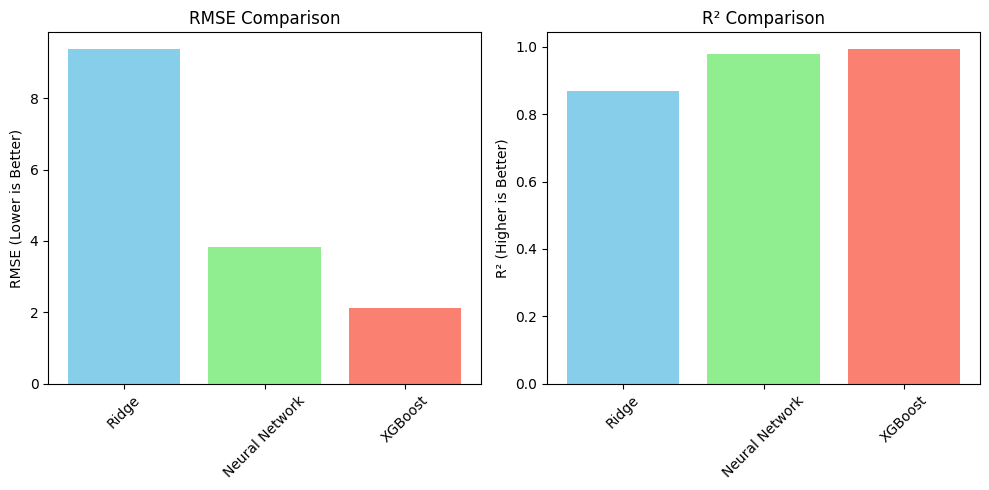

In [ ]:
print("Model Comparison:")
for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f"  RMSE        = {metrics['RMSE']:.2f}")
    print(f"  R²          = {metrics['R2']:.4f}")
    print(f"  Params = {metrics['Params']}")

# Extract metrics
model_names = list(results.keys())
rmse_values = [results[model]['RMSE'] for model in model_names]
r2_values = [results[model]['R2'] for model in model_names]

# Plot RMSE
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(model_names, rmse_values, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('RMSE Comparison')
plt.ylabel('RMSE (Lower is Better)')
plt.xticks(rotation=45)

# Plot R²
plt.subplot(1, 2, 2)
plt.bar(model_names, r2_values, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('R² Comparison')
plt.ylabel('R² (Higher is Better)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


## **Heart_disease**

### Model Training and Evaluation

In [ ]:
X_train = X_train_scaled
X_test = X_test_scaled

In [ ]:
# Store models and results to compare later
models = {}
results = {}

1. **Linear Regression with Ridge regularization**

In [ ]:
ridge = Ridge()
ridge_params = {
    'alpha': [0.01, 0.1, 1, 10, 100]
}
ridge_grid = GridSearchCV(ridge, ridge_params, cv=5, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train, y_train)
y_pred_ridge = ridge_grid.predict(X_test)

models['Ridge'] = ridge_grid.best_estimator_
results['Ridge'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_ridge)),
    'R2': r2_score(y_test, y_pred_ridge),
    'Params': ridge_grid.best_params_
}

logger.info(f"Ridge Regression evaluation complete. RMSE: {results['Ridge']['RMSE']:.4f}, R2: {results['Ridge']['R2']:.4f}, Best Params: {results['Ridge']['Params']}")

2025-05-08 16:04:57,256 - INFO - Ridge Regression evaluation complete. RMSE: 11.3340, R2: 0.8552, Best Params: {'alpha': 1}


2. **Neural Network**

In [ ]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1)  # Linear output for regression
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mse',
              metrics=['mse'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Extract Hyperparameters
def get_model_params(model):
    params = {}

    # Optimizer parameters
    if hasattr(model.optimizer, 'learning_rate'):
        params['learning_rate'] = float(model.optimizer.learning_rate.numpy())

    # Layer-specific parameters
    for layer in model.layers:
        if isinstance(layer, Dense):
            params[f'dense_units_{layer.name}'] = layer.units
            params[f'activation_{layer.name}'] = layer.activation.__name__
        elif isinstance(layer, Dropout):
            params[f'dropout_rate_{layer.name}'] = layer.rate
        elif isinstance(layer, BatchNormalization):
            params[f'batchnorm_{layer.name}'] = True

        return params

# Predict & Evaluate
y_pred_nn = model.predict(X_test).flatten()

# Store results
models['Neural Network'] = model
results['Neural Network'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_nn)),
    'R2': r2_score(y_test, y_pred_nn),
    'Params': get_model_params(model)
}

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1862.8135 - mse: 1862.8135 - val_loss: 827.4894 - val_mse: 827.4894
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 661.1460 - mse: 661.1460 - val_loss: 263.6336 - val_mse: 263.6336
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 209.7610 - mse: 209.7610 - val_loss: 55.0990 - val_mse: 55.0990
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 113.8728 - mse: 113.8728 - val_loss: 53.4861 - val_mse: 53.4861
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 105.5406 - mse: 105.5406 - val_loss: 53.0570 - val_mse: 53.0570
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 106.1163 - mse: 106.1163 - val_loss: 51.2633 - val_mse: 51.2633
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 103.7138 - mse: 103.7138 - val_loss: 52.4780 - val_mse: 52.4780
Epoch 8/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 93.7962 - mse: 93.7962 - val_loss: 52.1359 - val_mse: 52.1359
Epoch 9/50
400/

3. **XGBoost Regressor**

In [ ]:
# 3. XGBoost Regressor
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize base model
xgb_base = XGBRegressor(random_state=42)

# Grid search with 3-fold cross-validation
grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred_xgb = best_model.predict(X_test)

models['XGBoost'] = grid_search.best_params_
results['XGBoost'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_xgb)),
    'R2': r2_score(y_test, y_pred_xgb),
    'Params': grid_search.best_params_
}

Fitting 3 folds for each of 72 candidates, totalling 216 fits


**Models Comparison**

Model Comparison:
Ridge:
  RMSE        = 11.33
  R²          = 0.8552
  Params = {'alpha': 1}
Neural Network:
  RMSE        = 6.71
  R²          = 0.9493
  Params = {'learning_rate': 0.0010000000474974513, 'dense_units_dense_17': 64, 'activation_dense_17': 'relu'}
XGBoost:
  RMSE        = 6.38
  R²          = 0.9541
  Params = {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


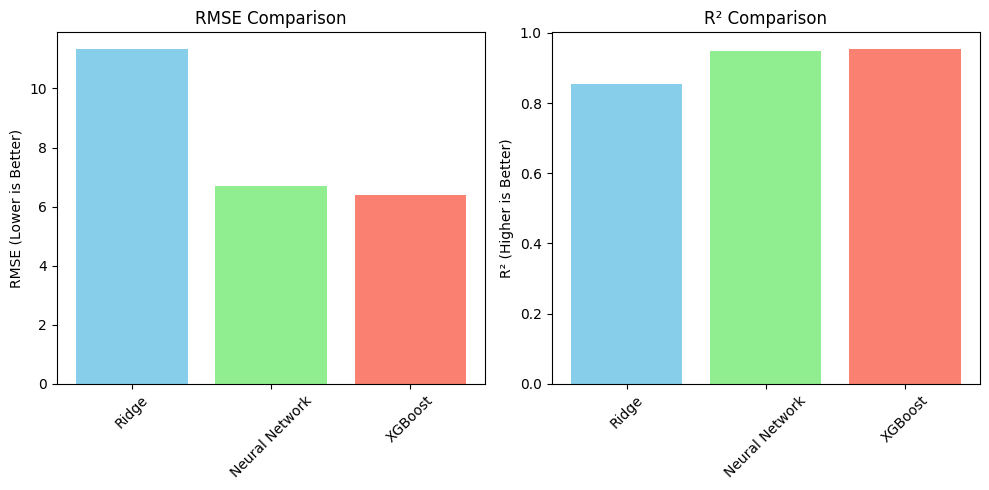

In [ ]:
print("Model Comparison:")
for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f"  RMSE        = {metrics['RMSE']:.2f}")
    print(f"  R²          = {metrics['R2']:.4f}")
    print(f"  Params = {metrics['Params']}")

# Extract metrics
model_names = list(results.keys())
rmse_values = [results[model]['RMSE'] for model in model_names]
r2_values = [results[model]['R2'] for model in model_names]

# Plot RMSE
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(model_names, rmse_values, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('RMSE Comparison')
plt.ylabel('RMSE (Lower is Better)')
plt.xticks(rotation=45)

# Plot R²
plt.subplot(1, 2, 2)
plt.bar(model_names, r2_values, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('R² Comparison')
plt.ylabel('R² (Higher is Better)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
